# 预处理和划分数据集

In [23]:
import chardet
#coding=utf-8
import numpy as np

import pandas as pd


# 获取文件编码类型
def get_encoding(file):
    # 二进制方式读取，获取字节数据，检测类型
    with open(file, 'rb') as f:
        return chardet.detect(f.read())['encoding']


def get_df(data_path):
    # encoding = get_encoding(data_path)
    # print(encoding)
    encoding = "GB2312"
    f = open(data_path, encoding=encoding, errors='ignore')
    data = pd.read_csv(f)
    return data


label_data = get_df("../../data/nCoV_100k_train.labled.csv")
unlabel_data = get_df("../../data/nCoV_900k_train.unlabled.csv")

label_data = label_data[['微博中文内容', '情感倾向']]
unlabel_data = unlabel_data[['微博中文内容']]

In [24]:
import re


def remove_useless(text):
    # 去掉转发对象 回复对象 超话
    rule1 = re.compile("//@.*:|回复@.*:|//////.*:|//:")
    # 去掉?展开全文c O网页链接 ...
    rule2 = re.compile("\?展开全文c|O网页链接\?*|原标题：|转发微博|网易链接|查看图片")
    # 去掉 无意义符号
    rule3 = re.compile("[#【】/-]")
    text = rule1.sub(" ", text)
    text = rule2.sub(" ", text)
    text = rule3.sub(" ", text)
    text = text.strip()
    return text


label_data['微博中文内容'] = label_data.apply(lambda x: remove_useless(str(x['微博中文内容'])), axis=1)
unlabel_data['微博中文内容'] = unlabel_data.apply(lambda x: remove_useless(str(x['微博中文内容'])), axis=1)



In [26]:
# 去除情感倾向不在[-1,0,1]的
label_data = label_data[label_data['情感倾向'].astype('str').isin(["-1", "0", "1"])]

# 删除重复值
label_data.drop_duplicates(subset=['微博中文内容'], keep='first', inplace=True)
unlabel_data.drop_duplicates(subset=['微博中文内容'], keep='first', inplace=True)

import numpy as np


# 删除空值
def replace_to_nan(text: str):
    if text.isspace():
        return np.nan
    return text


label_data['微博中文内容'] = label_data.apply(lambda x: replace_to_nan(str(x['微博中文内容'])), axis=1)
unlabel_data['微博中文内容'] = unlabel_data.apply(lambda x: replace_to_nan(str(x['微博中文内容'])), axis=1)

label_data.dropna(axis=0, inplace=True)
unlabel_data.dropna(axis=0, inplace=True)

label_data.groupby(['情感倾向']).count()


,微博中文内容
情感倾向,
-1,15655
0,49368
1,21782


In [29]:
label_data.to_csv("../../data/post_process/train_labeled.csv", index=False)
unlabel_data.to_csv("../../data/post_process/train_unlabeled.csv", index=False)

In [38]:
from torch.utils.data import Dataset, random_split


class MyDataSet(Dataset):
    def __init__(self, loaded_data):
        self.data = loaded_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


label_data.reset_index(drop=True, inplace=True)
custom_dataset = MyDataSet(label_data)
# 按照比例划分
train_size = int(len(custom_dataset) * 0.8)
validate_size = int(len(custom_dataset) * 0.2)
train_dataset, validate_dataset = random_split(
    custom_dataset, [train_size, validate_size])

# 设置保存路径
train_data_path = "../../data/input/train.csv"
dev_data_path = "../../data/input/dev.csv"

train = train_dataset.dataset.data.loc[train_dataset.indices]
dev = validate_dataset.dataset.data.loc[validate_dataset.indices]

train_dataset.dataset.data.loc[train_dataset.indices].to_csv(train_data_path, index=False, header=True,
                                                             encoding="GB2312")
validate_dataset.dataset.data.loc[validate_dataset.indices].to_csv(dev_data_path, index=False, header=True,
                                                                   encoding="GB2312")

# 数据集简单分析

In [7]:
import pandas as pd

f=open("../../data/post_process/train_labeled.csv", encoding="UTF-8", errors="ignore")
label_data = pd.read_csv(f)

f=open("../../data/post_process/train_unlabeled.csv", encoding="UTF-8", errors="ignore")
unlabel_data = pd.read_csv(f)




In [8]:
label_data.groupby(['情感倾向']).count()

,微博中文内容
情感倾向,
-1,15655
0,49367
1,21781


In [25]:
label_data.groupby(by=label_data['微博中文内容'].str.len()).count()

,微博中文内容,情感倾向
微博中文内容,,
1.0,50,50
2.0,179,179
3.0,235,235
4.0,453,453
5.0,472,472
...,...,...
217.0,1,1
219.0,3,3
221.0,1,1


<BarContainer object of 206 artists>

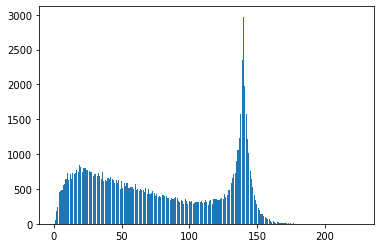

In [21]:
label_cnt=label_data.groupby(by=label_data['微博中文内容'].str.len()).count()
# max_len=225

import matplotlib.pyplot as plt
%matplotlib inline

x=list(label_cnt.index.astype('int'))
y=list(label_cnt['微博中文内容'])
plt.bar(x,y)

In [24]:
unlabel_data.groupby(by=unlabel_data['微博中文内容'].str.len()).count()
# x=list(unlabel_cnt.index.astype('int'))
# y=list(unlabel_cnt['微博中文内容'])
# plt.bar(x,y)

,微博中文内容
微博中文内容,
1.0,184
2.0,833
3.0,1324
4.0,2667
5.0,3015
...,...
278.0,1
280.0,2
296.0,1


In [11]:
import datetime

"{}".format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

'2022-07-27 14:38:37'